### CP#34 - IncomeInsight: Predicting Earning Potential from Demographic & Employment Data

Exporatory Data Analysis  
URL: https://www.kaggle.com/datasets/uciml/adult-census-income

Findings:
- There are no empty cells, and only integer and object types
- Sex and Income (<=50K, >50K) are binary objects
- Capital gain and loss are heavily skewed and can be represented as binary
- ? marks are in workclass, occupation and native.country columns
- ? marks appear randomly distributed and make up ~7% of records - dropped from analysis
- education.num has the strongest correlation with earning >$50K, a second tier is led by whether there are capital gains or not, followed closely by age and hours.per.week
- Higher education levels (education.num) and more hours per week generally correspond to higher    income.
- Married individuals are more likely to earn >$50K than singles.
- Males are more likely than females to earn >$50K.
- Asian-Pacific-Islanders had the highest percentage of high earners, and White individuals were a close second but with far more representation
- Native country also plays a role, with the US at the bottom of the top seven with percentage of high earners, and substantially more represented
- Individuals with non-zero capital.gain values are significantly more likely to earn >$50K

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
from joblib import dump
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

sns.set(style="whitegrid")

In [208]:
# Download the dataset
kaggle.api.dataset_download_files('uciml/adult-census-income', path='../data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/uciml/adult-census-income


In [209]:
data = pd.read_csv("../data/adult.csv")
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Task 1:  Handle missing values and inconsistent formatting (e.g., “?” entries)

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [211]:
unique_counts = data.nunique()
print(unique_counts)

age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64


In [212]:
data.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [213]:
# Get lists of column names by type
bin_cols = ['sex', 'income']
int_cols = data.select_dtypes(include='int').columns.tolist()
obj_cols = data.select_dtypes(include='object').columns.tolist()

# Remove binary columns from object columns
obj_cols = list(set(obj_cols) - set(bin_cols))

print("Binary columns:", bin_cols)
print("Integer columns:", int_cols)
print("Object columns:", obj_cols)

Binary columns: ['sex', 'income']
Integer columns: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Object columns: ['education', 'relationship', 'marital.status', 'race', 'occupation', 'workclass', 'native.country']


In [214]:
# List unique values in text columns
for col in bin_cols:
    print(f"Unique values in '{col}':")
    print(sorted(data[col].unique()))
    print()

for col in obj_cols:
    print(f"Unique values in '{col}':")
    print(sorted(data[col].unique()))
    print()

Unique values in 'sex':
['Female', 'Male']

Unique values in 'income':
['<=50K', '>50K']

Unique values in 'education':
['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college']

Unique values in 'relationship':
['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']

Unique values in 'marital.status':
['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']

Unique values in 'race':
['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']

Unique values in 'occupation':
['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']

Unique values in 'workclass':
['?', 'Fed

In [215]:
# How many missing values are there using the question mark?
missing_counts = {}
for col_name in ['workclass', 'occupation', 'native.country']:
    missing_counts[col_name] = (data[col_name] == '?').sum()
print(missing_counts)

{'workclass': np.int64(1836), 'occupation': np.int64(1843), 'native.country': np.int64(583)}


In [216]:
# Percentage of rows with any "?" in object columns
rows_with_question = data[obj_cols].apply(lambda row: row.str.contains(r'\?')).any(axis=1).sum()
percentage = (rows_with_question / len(data)) * 100
print(f"Percentage of rows containing '?': {percentage:.2f}%")

Percentage of rows containing '?': 7.37%


In [217]:
# Are the "?" entries randomly distributed?

# Add a column indicating if any object column has a "?" entry
data['has_question'] = data[obj_cols].apply(lambda row: row.str.contains(r'\?')).any(axis=1)

# Compare mean age (or other features) for rows with and without "?"
print("Age statistics by 'has_question':")
print(data.groupby('has_question')['age'].describe())
print()

# Gender statistics: number of 'Male' records with has_question True and total 'Male' records
num_male_with_question = ((data['sex'] == 'Male') & (data['has_question'])).sum()
num_male_total = (data['sex'] == 'Male').sum()
print(f"Number of 'Male' records with has_question=True: {num_male_with_question}")
print(f"Total number of 'Male' records: {num_male_total}")
if num_male_total > 0:
    print(f"Proportion: {num_male_with_question / num_male_total:.2%}")
print()

# Gender statistics: number of 'Female' records with has_question True and total 'Female' records
num_female_with_question = ((data['sex'] == 'Female') & (data['has_question'])).sum()
num_female_total = (data['sex'] == 'Female').sum()
print(f"Number of 'Female' records with has_question=True: {num_female_with_question}")
print(f"Total number of 'Female' records: {num_female_total}")
if num_female_total > 0:
    print(f"Proportion: {num_female_with_question / num_female_total:.2%}")
print()

# Compare income distribution
print(data.groupby('has_question')['income'].value_counts(normalize=True))


Age statistics by 'has_question':
                count       mean        std   min   25%   50%   75%   max
has_question                                                             
False         30162.0  38.437902  13.134665  17.0  28.0  37.0  47.0  90.0
True           2399.0  40.388912  18.786609  17.0  22.0  36.0  58.0  90.0

Number of 'Male' records with has_question=True: 1410
Total number of 'Male' records: 21790
Proportion: 6.47%

Number of 'Female' records with has_question=True: 989
Total number of 'Female' records: 10771
Proportion: 9.18%

has_question  income
False         <=50K     0.751078
              >50K      0.248922
True          <=50K     0.861192
              >50K      0.138808
Name: proportion, dtype: float64


With roughly similar distribution of question marks, they appear to be random.  And at less than 10% of our data, it appears acceptable to delete these incomplete records.

In [218]:
# Delete rows with "?" in object columns
data_cleaned = data[~data['has_question']].drop(columns=['has_question'])

In [219]:
# Binary encoding for income, sex, capital gain & loss columns
data_cleaned['income_bin'] = data_cleaned['income'].apply(lambda x: 1 if x == '>50K' else 0)
data_cleaned['sex_bin'] = data_cleaned['sex'].apply(lambda x: 1 if x == 'Male' else 0)
data_cleaned['gain_bin'] = data_cleaned['capital.gain'].apply(lambda x: 1 if x > 0 else 0)
data_cleaned['loss_bin'] = data_cleaned['capital.loss'].apply(lambda x: 1 if x > 0 else 0)

Correlation heatmap

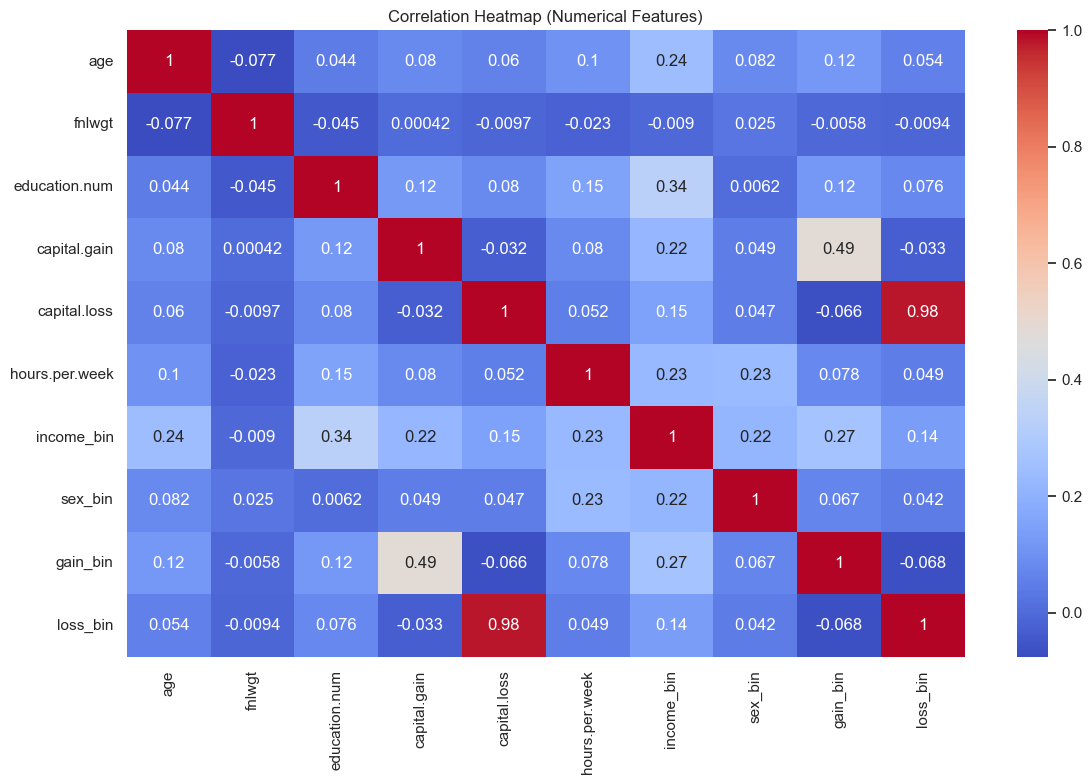

In [220]:
# Correlation of numerical features
num_cols = data_cleaned.select_dtypes(include='number')
corr = num_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numerical Features)")
plt.tight_layout()
plt.show()

Distribution plots

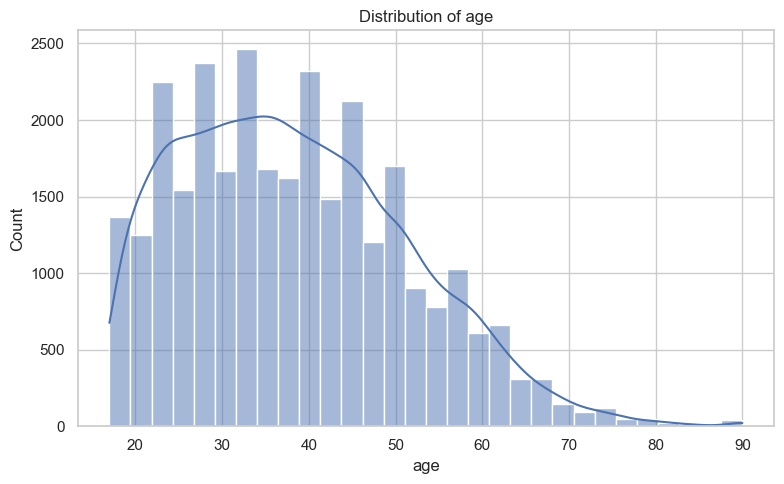

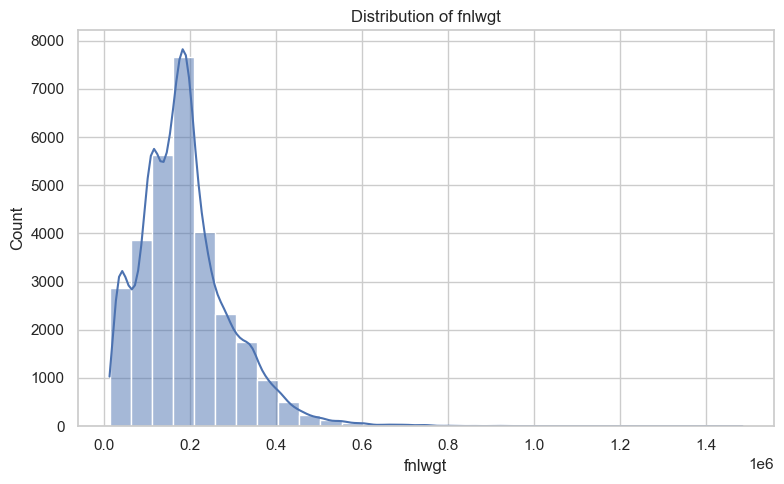

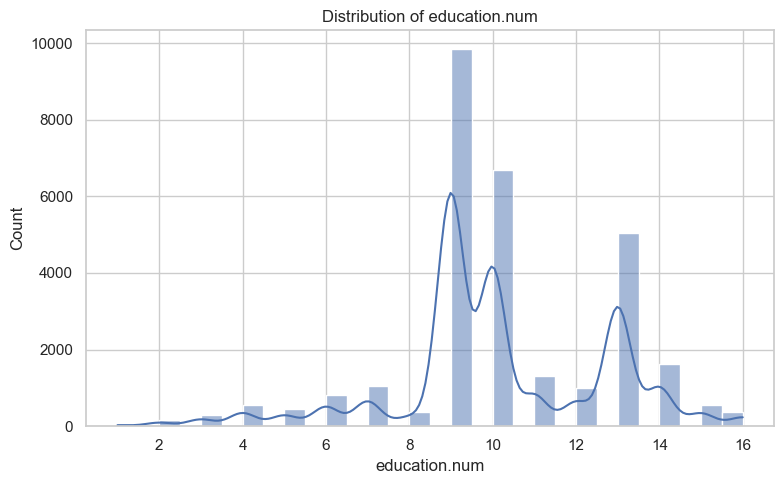

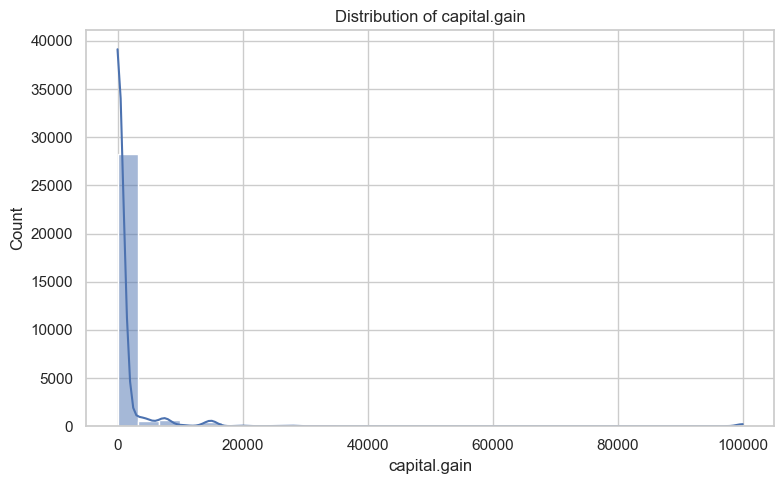

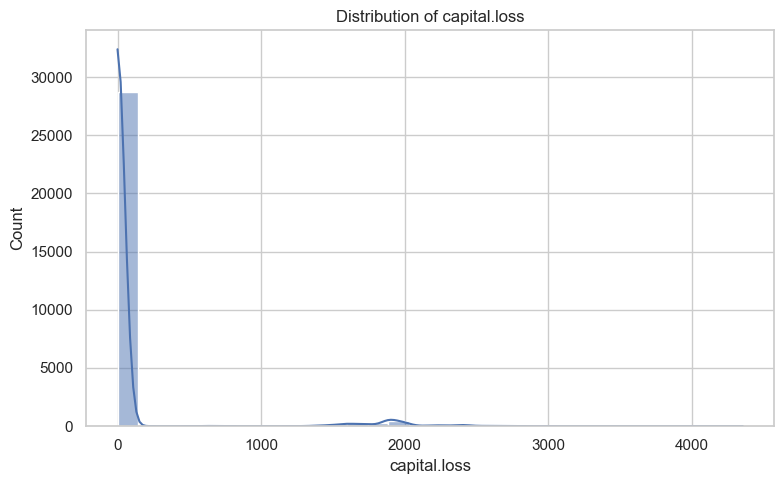

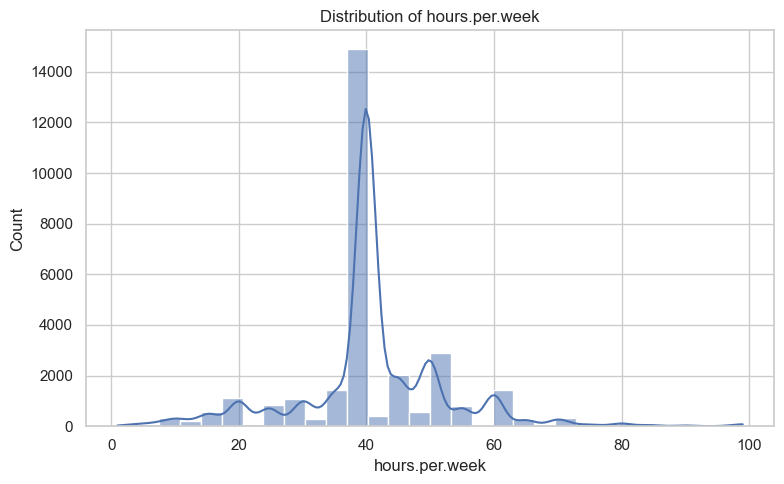

In [221]:
# Distribution plots for key numeric features
for col in int_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data_cleaned[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

Income proportions

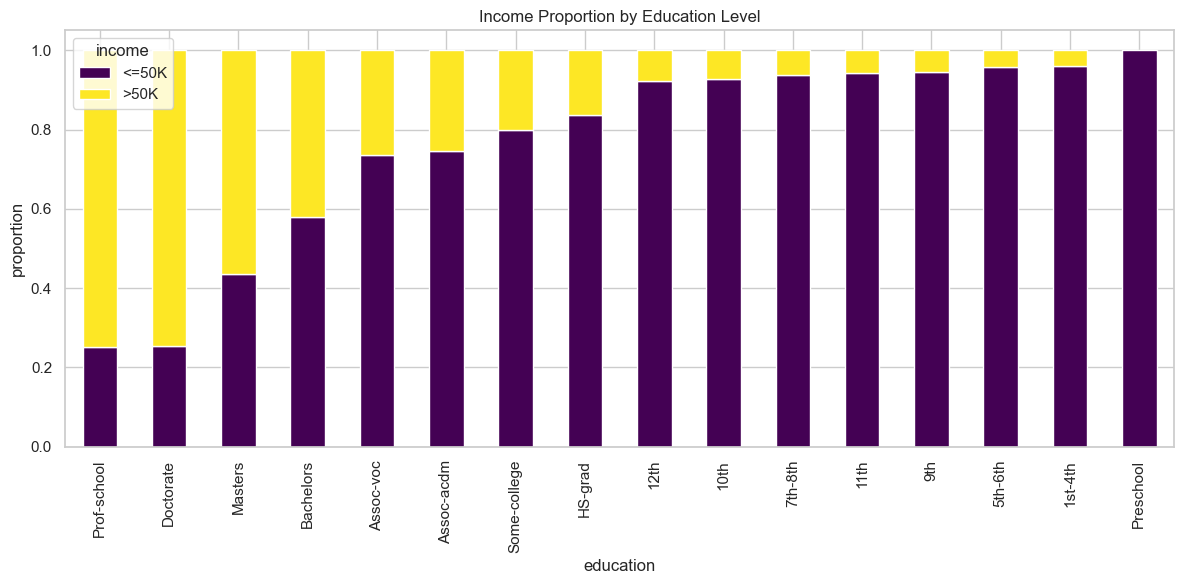

In [222]:
# Income proportions by education level
edu_income = pd.crosstab(data_cleaned['education'], data_cleaned['income'], normalize='index')
edu_sorted = edu_income.sort_values(by='>50K', ascending=False)

edu_sorted.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Income Proportion by Education Level')
plt.ylabel('proportion')
plt.tight_layout()
plt.show()

Task 2:  Encode categorical features and normalize continuous ones

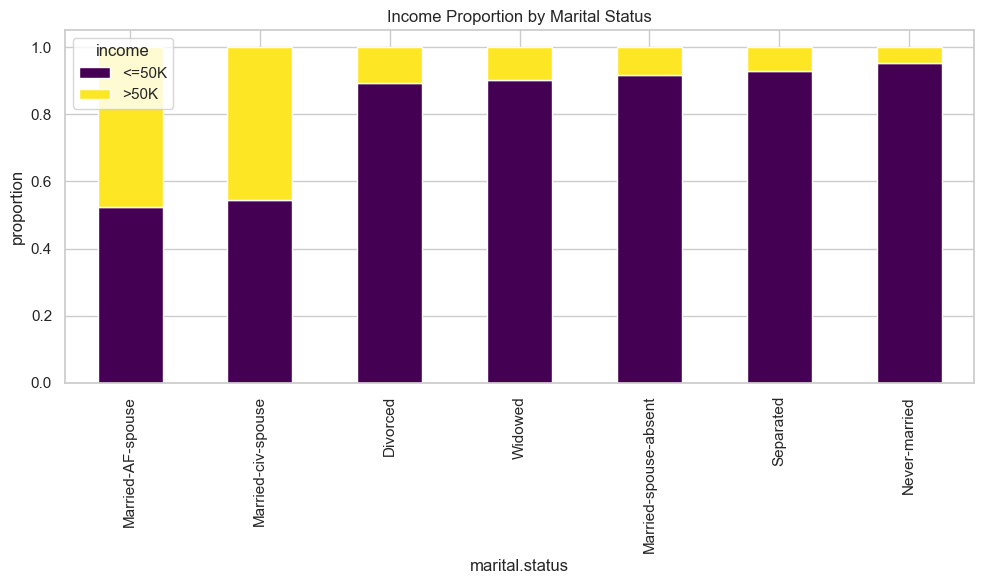

In [223]:
# Income proportions by marital status
marital_income = pd.crosstab(data_cleaned['marital.status'], data_cleaned['income'], normalize='index')
marital_sorted = marital_income.sort_values(by='>50K', ascending=False)
marital_sorted.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Income Proportion by Marital Status')
plt.ylabel('proportion')
plt.tight_layout()
plt.show()

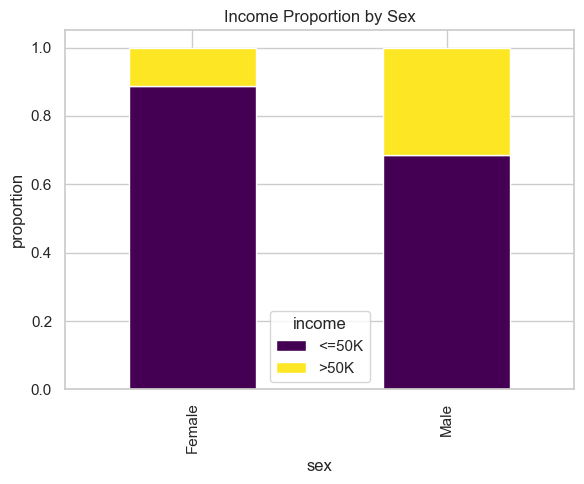

In [224]:
# Income proportions by sex
sex_income = pd.crosstab(data_cleaned['sex'], data_cleaned['income'], normalize='index')
sex_income.plot(kind='bar', stacked=True, figsize=(6, 5), colormap='viridis')
plt.title('Income Proportion by Sex')
plt.ylabel('proportion')
plt.tight_layout()
plt.show()

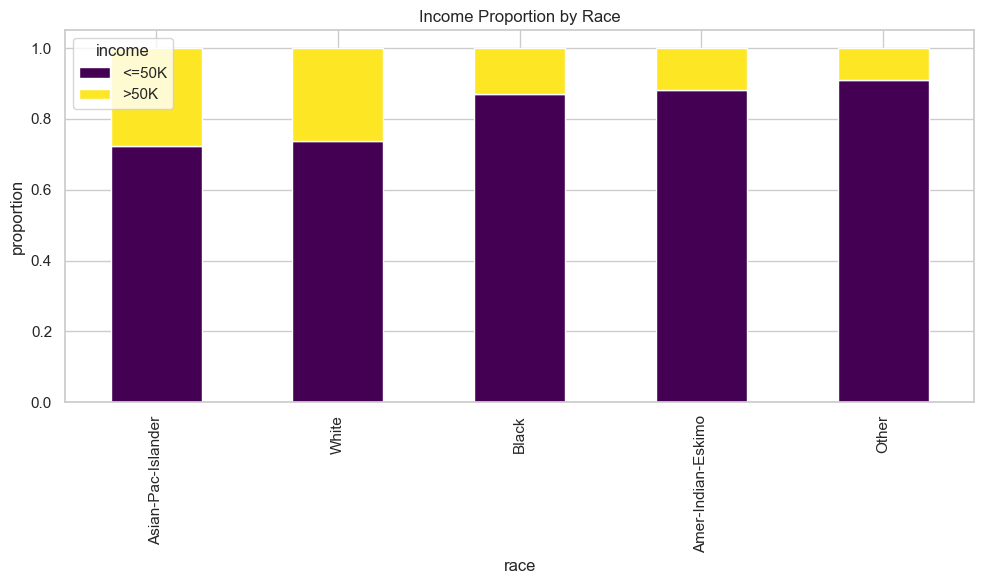

In [225]:
# Income proportions by race
race_income = pd.crosstab(data_cleaned['race'], data_cleaned['income'], normalize='index')
race_sorted = race_income.sort_values(by='>50K', ascending=False)
race_sorted.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Income Proportion by Race')
plt.ylabel('proportion')
plt.tight_layout()
plt.show()

In [226]:
# race by representation
data_cleaned.groupby('race')['race'].count().sort_values(ascending=False)

race
White                 25933
Black                  2817
Asian-Pac-Islander      895
Amer-Indian-Eskimo      286
Other                   231
Name: race, dtype: int64

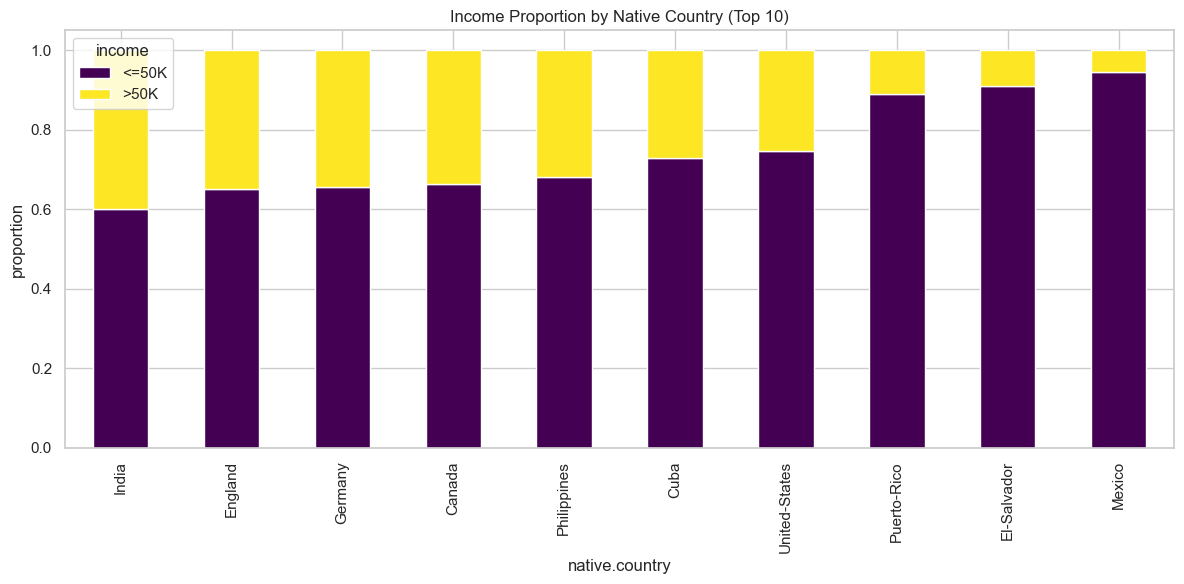

In [227]:
# Income proportions by native country (top 10)
top_countries = data_cleaned['native.country'].value_counts().nlargest(10).index
top_country_df = data_cleaned[data_cleaned['native.country'].isin(top_countries)]

country_income = pd.crosstab(top_country_df['native.country'], top_country_df['income'], normalize='index')
country_sorted = country_income.sort_values(by='>50K', ascending=False)
country_sorted.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Income Proportion by Native Country (Top 10)')
plt.ylabel('proportion')
plt.tight_layout()
plt.show()

In [228]:
top_country_df.groupby('native.country')['native.country'].count().sort_values(ascending=False)

native.country
United-States    27504
Mexico             610
Philippines        188
Germany            128
Puerto-Rico        109
Canada             107
India              100
El-Salvador        100
Cuba                92
England             86
Name: native.country, dtype: int64

Hours worked per week by income group

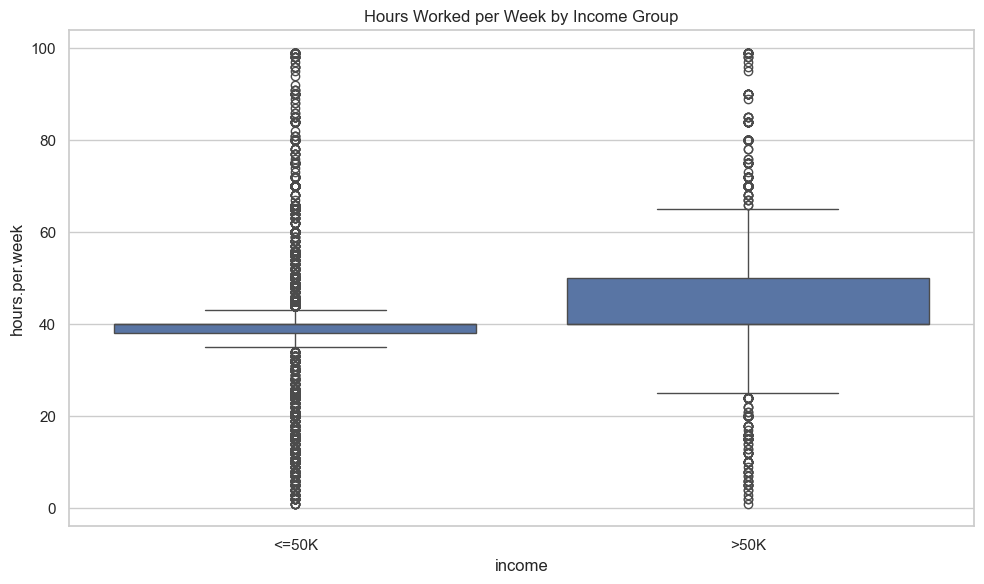

In [229]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='income', y='hours.per.week', data=data_cleaned)
plt.title('Hours Worked per Week by Income Group')
plt.tight_layout()
plt.show()

Preprocessing with encoding and scaling

In [230]:
# Binary mapping function
def map_binary_cols(X):
    return pd.DataFrame({
        'sex': X['sex'].map({'Male': 1, 'Female': 0}),
        'income': X['income'].map({'>50K': 1, '<=50K': 0})
    })

# Define transformers
binary_transformer = FunctionTransformer(map_binary_cols, validate=False)

onehot_transformer = OneHotEncoder(drop='first', sparse_output=False)

scaler_transformer = StandardScaler()

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('bin', binary_transformer, bin_cols),
    ('cat', onehot_transformer, obj_cols),
    ('num', scaler_transformer, int_cols)
])

# Final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform
data_transformed = pipeline.fit_transform(data_cleaned)

Output

In [231]:
dump(pipeline, '../models/model_pipeline.pkl')

['../models/model_pipeline.pkl']

In [233]:
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(obj_cols)
final_feature_names = bin_cols + list(ohe_feature_names) + int_cols

# Convert transformed array to DataFrame
data_transformed_df = pd.DataFrame(data_transformed, columns=final_feature_names)

data_transformed_df.to_csv("../data/adult_converted.csv")